# Reservoir + Lasso Regularization

In [1]:
import random
import numpy as np
import math 
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import time

In [2]:
# ============================================================
# Reservoir + Lasso 2.0
# Author: Davide Rossetti, PhD
# ============================================================

# --- Imports ---
import random
import numpy as np
import math
from sklearn.linear_model import MultiTaskLassoCV, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# For reproducibility
random.seed(42)
np.random.seed(42)


# ============================================================
# Nonlinear functions defining the dynamical system
# ============================================================

def a(x, y, z, r, k):
    """Nonlinear update function for variable x."""
    alpha = x ** 3
    return 2 * (r - 1) * x - 4 * r * alpha - k * (x - y)

def a1(x, y, z, r, k):
    """Nonlinear update function for variable y."""
    beta = y ** 3
    return 2 * (r - 1) * y - 4 * r * beta - k * ((y - x) + (y - z))

def a2(x, y, z, r, k):
    """Nonlinear update function for variable z."""
    gamma = z ** 3
    return 2 * (r - 1) * z - 4 * r * gamma - k * (z - y)



# ============================================================
# Load dataset and labels generated externally with r = 2.5
# ============================================================

# Load dataset (X)
with open("Dataset_R250.txt", "r") as file:
    matrix = []
    for line in file:
        line = line.strip()
        if not line:
            continue
        row = [float(v) for v in line.split()]
        matrix.append(row)
X = np.array(matrix)

# Load labels (y)
with open("Label_R250.txt", "r") as file:
    matrix1 = []
    for line in file:
        line = line.strip()
        if not line:
            continue
        row = [float(v) for v in line.split()]
        matrix1.append(row)
y = np.array(matrix1)

print(f"Dataset loaded successfully: X shape = {X.shape}, y shape = {y.shape}")


# ============================================================
# Split dataset into training and testing sets
# ============================================================

dim_test = 100000  # number of test samples
X_train = X[dim_test:len(X)]
X_test = X[len(X) - dim_test:]
y_train = y[dim_test:len(y)]
y_test = y[len(y) - dim_test:]

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Dataset loaded successfully: X shape = (1000010, 3), y shape = (1000010, 3)
Training samples: 900010, Testing samples: 100000


In [3]:
# ============================================================
# Reservoir Computing Model
# ============================================================

class ReservoirComputing:
    """
    A simplified reservoir computing model.
    It transforms input time series into high-dimensional states.
    """

    def __init__(self, reservoir_size, input_size):
        self.reservoir_size = reservoir_size
        self.input_size = input_size
        # Initialize input weight matrix with small random values
        self.W_in = np.random.rand(input_size, reservoir_size) - 0.5

    def train(self, inputs):
        """
        Propagate the input through the reservoir layer.
        Returns a transformed representation of the input.
        """
        X_reservoir = np.zeros((len(inputs), self.reservoir_size))
        for t in range(len(inputs)):
            # Multiply input vector by input weight matrix
            input_weighted = np.dot(inputs[t], self.W_in)
            X_reservoir[t] = input_weighted
        return X_reservoir

    
# ============================================================
# Create the reservoir model, build feature matrix, and train LASSO
# (This keeps your original "Metodo Facile" with fixed alpha)
# ============================================================

reservoir_size = 100
input_size = 3

# Create reservoir model
rc_model = ReservoirComputing(reservoir_size, input_size)

# Transform training inputs through the reservoir (feature expansion)
X = rc_model.train(X_train)

# Simple LASSO baseline with fixed regularization (your original choice)
lasso = Lasso(alpha=0.0000005, max_iter=20000)  # alpha = 5e-7
lasso.fit(X, y_train)

# Inspect coefficients
coefficients = lasso.coef_          # shape: (3, reservoir_size) for multi-output
intercept = lasso.intercept_

print("[INFO] LASSO training completed.")
print(f"[INFO] Coefficients shape: {coefficients.shape} | Intercept shape: {intercept.shape}")
    

[INFO] LASSO training completed.
[INFO] Coefficients shape: (3, 100) | Intercept shape: (3,)



[INFO] Starting trajectory 1/10 | Δy = 1.52268e-02


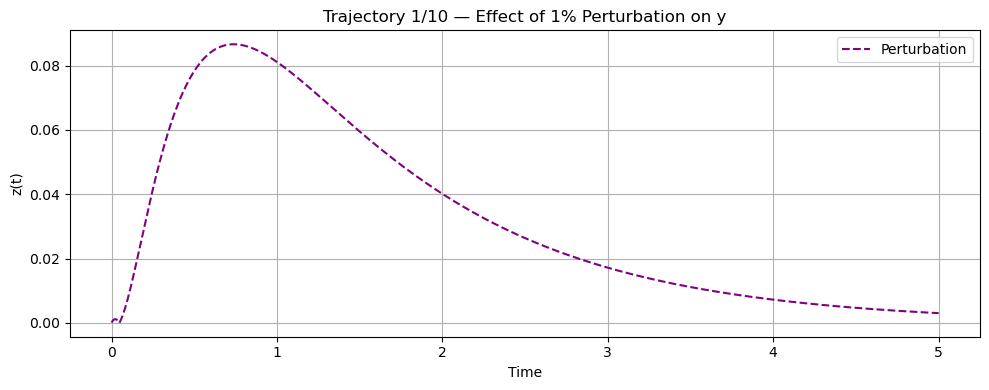

[INFO] Trajectory 1 completed and plotted.

[INFO] Starting trajectory 2/10 | Δy = 1.43075e-04


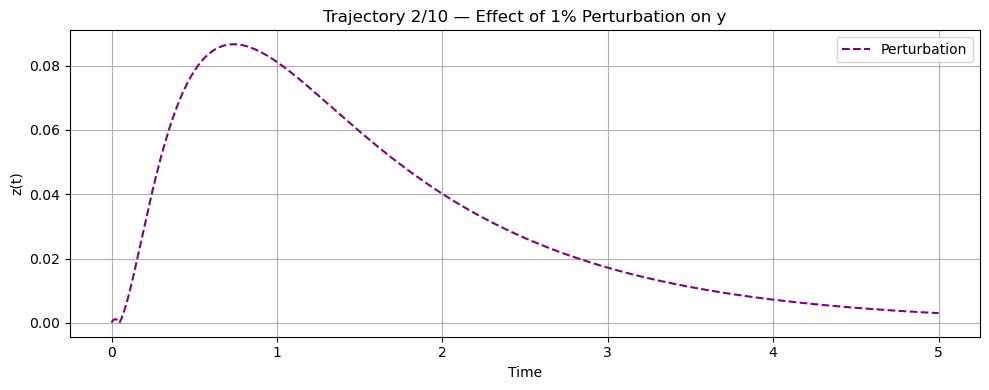

[INFO] Trajectory 2 completed and plotted.

[INFO] Starting trajectory 3/10 | Δy = -5.05601e-03


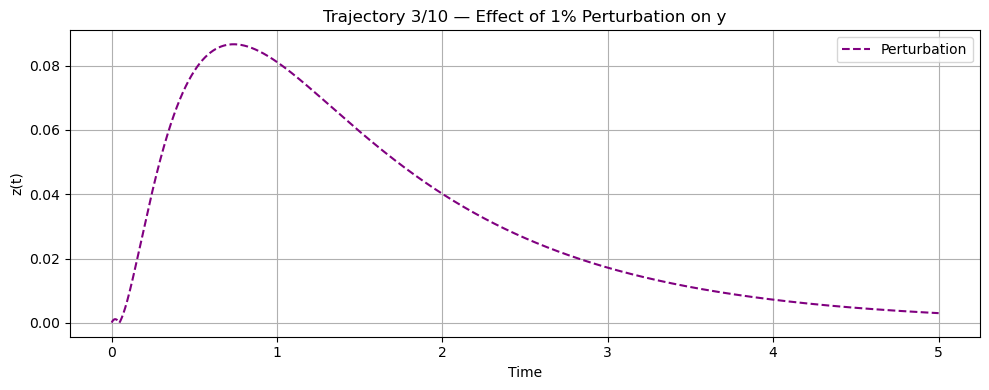

[INFO] Trajectory 3 completed and plotted.

[INFO] Starting trajectory 4/10 | Δy = -1.61348e-03


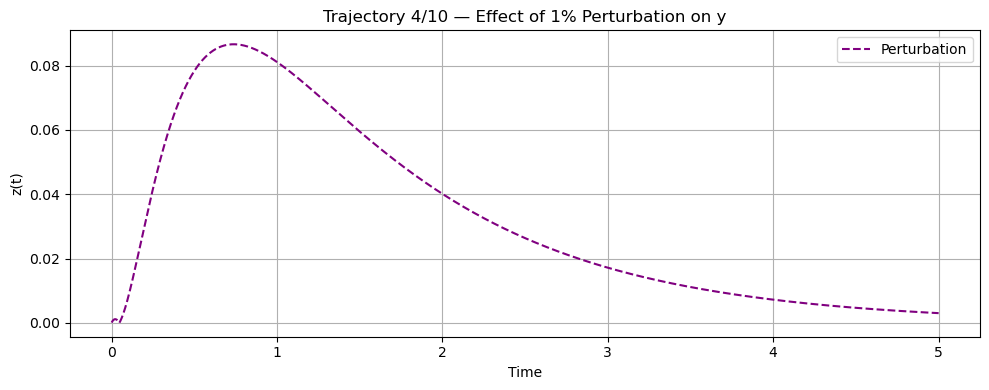

[INFO] Trajectory 4 completed and plotted.

[INFO] Starting trajectory 5/10 | Δy = 4.80898e-03


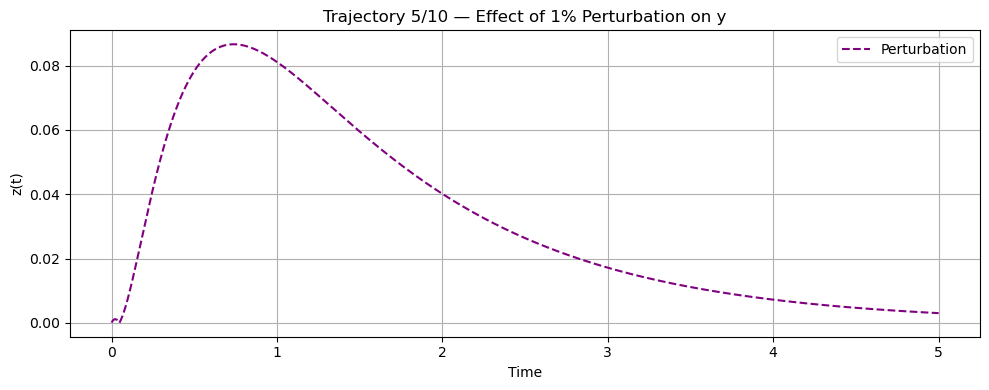

[INFO] Trajectory 5 completed and plotted.

[INFO] Starting trajectory 6/10 | Δy = -9.99974e-03


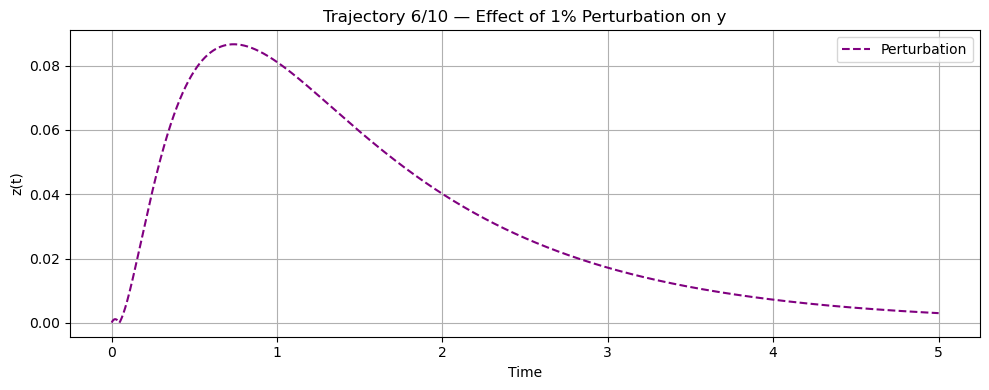

[INFO] Trajectory 6 completed and plotted.

[INFO] Starting trajectory 7/10 | Δy = -2.44616e-04


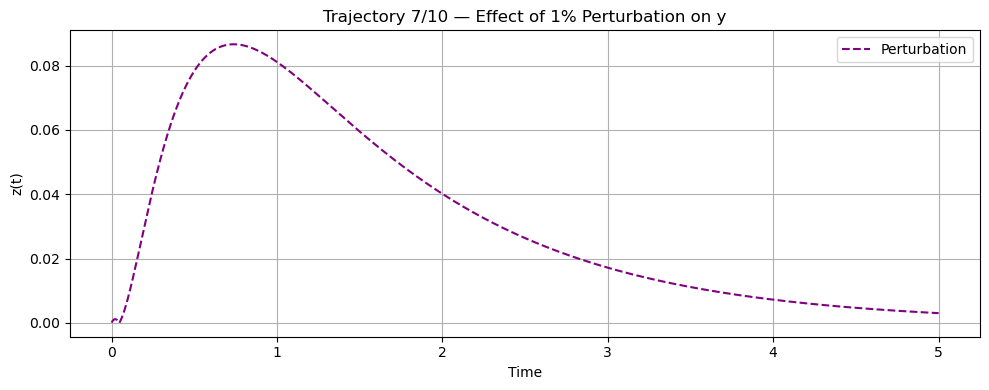

[INFO] Trajectory 7 completed and plotted.

[INFO] Starting trajectory 8/10 | Δy = -1.08600e-02


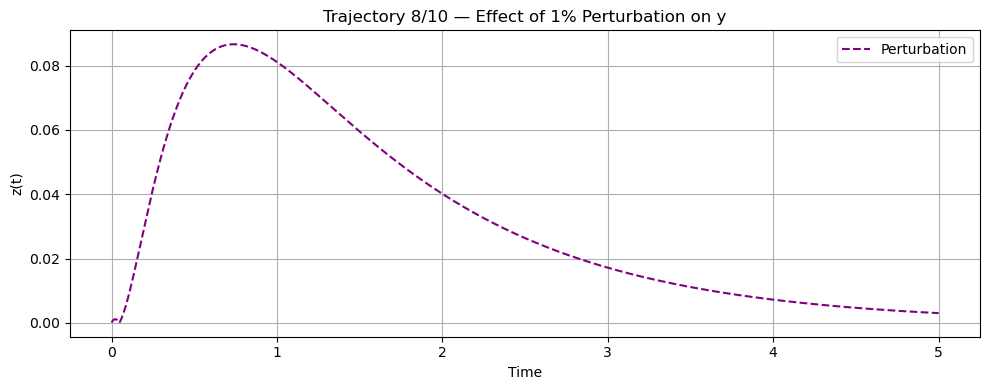

[INFO] Trajectory 8 completed and plotted.

[INFO] Starting trajectory 9/10 | Δy = -5.30323e-03


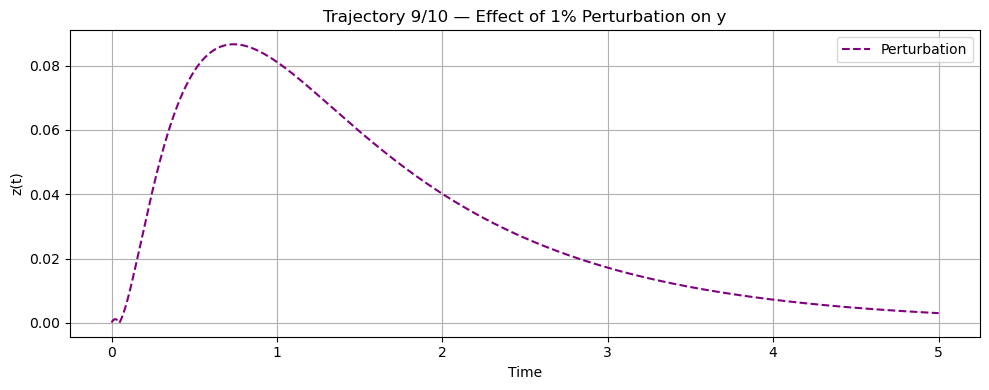

[INFO] Trajectory 9 completed and plotted.

[INFO] Starting trajectory 10/10 | Δy = -1.80189e-02


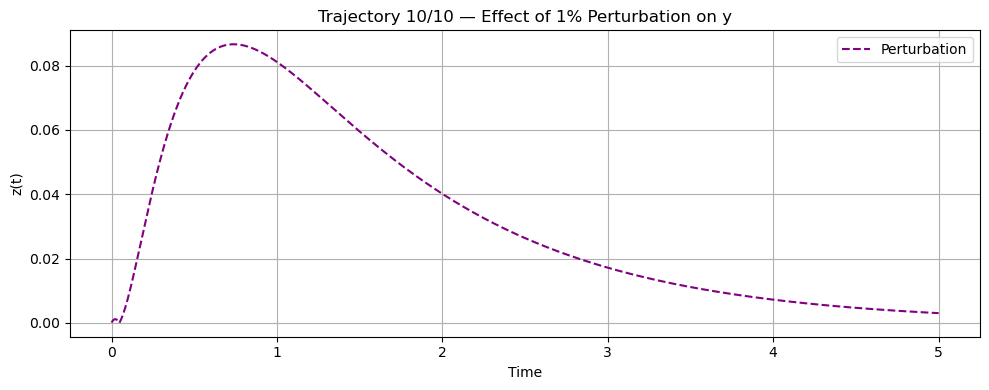

[INFO] Trajectory 10 completed and plotted.


In [5]:
# ============================================================
# Generate multiple trajectories and compare REAL vs PREDICTED curves
# (Faithful to your integration scheme; plots z(t) for both)
# ============================================================

# Parameters (kept as in your original code; only trajectories reduced to 10)
dt = 0.001
T = 5000
b = 1
k = 1
mu, sigma = 0, 1
transtime = 10000
r = 2.5
traiettorie = 10         # reduced from 80 to 10 as requested
ntr = 5000
lenseq = 100
x = np.linspace(0, 5, ntr)

# Allocate arrays
real = np.zeros((traiettorie, ntr, 3))   # real system evolution
copia = np.zeros((traiettorie, ntr, 3))  # model-predicted evolution
y=np.zeros((traiettorie,ntr))

for d in range(traiettorie):

    # --- Initialize system state ---
    M = np.zeros((T + 1, 3))
    M[0, 0], M[0, 1], M[0, 2] = np.random.normal(mu, sigma, 3)

    # --- Transient phase to reach attractor ---
    for t in range(transtime + 1):
        var, var1, var2 = M[0, 0], M[0, 1], M[0, 2]

        # Predictor (Euler)
        seed_value = int(time.time() * 1000) % 2**32
        random.seed(seed_value)
        np.random.seed(seed_value)

        x_temp = var  + dt * a(var, var1, var2, r, k) + b * np.random.normal(mu, np.sqrt(dt))
        y_temp = var1 + dt * a1(var, var1, var2, r, k) + b * np.random.normal(mu, np.sqrt(dt))
        z_temp = var2 + dt * a2(var, var1, var2, r, k) + b * np.random.normal(mu, np.sqrt(dt))

        # Corrector (Heun)
        M[0,0] =var+0.5*(a(var,var1,var2,r,k)+a(x_temp,y_temp,z_temp,r,k))*dt+0.5*b*2*(np.random.normal(mu, np.sqrt(dt)))
        M[0,1] =var1+0.5*(a1(var,var1,var2,r,k)+a1(x_temp,y_temp,z_temp,r,k))*dt+0.5*b*2*(np.random.normal(mu, np.sqrt(dt)))
        M[0,2] =var2+0.5*(a2(var,var1,var2,r,k)+a2(x_temp,y_temp,z_temp,r,k))*dt+0.5*b*2*(np.random.normal(mu, np.sqrt(dt)))
    

    # --- Initialize the two close states ---
    m = np.zeros((2, 3))
    m_exp = np.zeros((2, reservoir_size))

    # Both start from same stabilized point
    m[0] = np.copy([M[0, 0], M[0, 1], M[0, 2]])
    m[1] = np.copy([M[0, 0], M[0, 1], M[0, 2]])

    # Apply a tiny perturbation on y in the second system
    delta_y = M[0, 1] / 100
    m[1, 1] += delta_y

    print(f"\n[INFO] Starting trajectory {d+1}/{traiettorie} | Δy = {delta_y:.5e}")

    # --- Evolve both systems using only the model (no real system integration) ---
    for i in range(ntr):
        # Propagate both states through the reservoir
        m_exp = rc_model.train(m)

        # Predict next states for both systems
        predictions = lasso.predict(m_exp)

        # Store results
        real[d, i] = predictions[0]   # first system
        copia[d, i] = predictions[1]  # second system

        # Update current states for the next step
        m[0] = predictions[0]
        m[1] = predictions[1]
        
    for i in range(ntr):
        y[d,i]=(abs(real[d,i,2]-copia[d,i,2]))/abs(delta_y) 
    # --- Plot both trajectories for z variable ---
    plt.figure(figsize=(10, 4))
    plt.plot(x, y[d], "--", label="Perturbation", color="purple", linewidth=1.5)
    #plt.plot(x, real[d, :, 2], label="System A (original)", color="black", linewidth=2)
    #plt.plot(x, copia[d, :, 2], "--", label="System B (perturbed)", color="purple", linewidth=1.5)
    plt.xlabel("Time")
    plt.ylabel("z(t)")
    plt.title(f"Trajectory {d+1}/{traiettorie} — Effect of 1% Perturbation on y")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"[INFO] Trajectory {d+1} completed and plotted.")

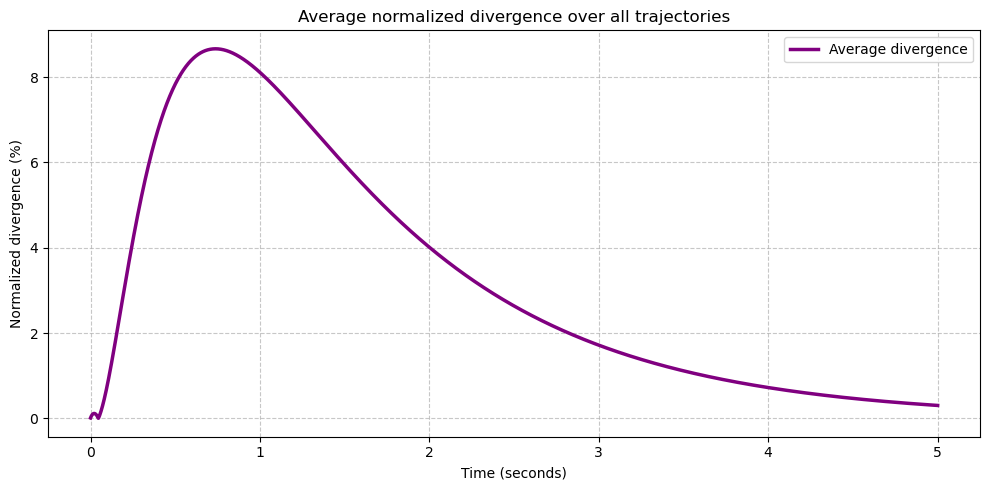

[INFO] Mean divergence curve successfully computed and plotted.


In [6]:
# ============================================================
#  Average divergence curve across all trajectories
# ============================================================

# Compute mean curve over all trajectories
y_mean = np.mean(y, axis=0)  # shape: (ntr,)

# Convert y-axis to percentage
y_mean_percent = y_mean * 100.0

# Time axis in seconds (already in your x)
time_sec = np.linspace(0, ntr * dt, ntr)  # or simply use your x if it's in seconds

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(time_sec, y_mean_percent, color="purple", linewidth=2.5, label="Average divergence")
plt.xlabel("Time (seconds)")
plt.ylabel("Normalized divergence (%)")
plt.title("Average normalized divergence over all trajectories")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

print("[INFO] Mean divergence curve successfully computed and plotted.")
